In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from sklearn import tree
from sklearn.tree import export_graphviz
import graphviz
import matplotlib.pyplot as plt


## Data cleaning
We first read in the NYC DOB data.

In [2]:
url = 'https://raw.githubusercontent.com/statds/ids-s22/main/notes/data/nyc_DobJobApp_2021.csv'
dob = pd.read_csv(url)
dob.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20087 entries, 0 to 20086
Data columns (total 96 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Job #                          20087 non-null  int64  
 1   Doc #                          20087 non-null  int64  
 2   Borough                        20087 non-null  object 
 3   House #                        20087 non-null  object 
 4   Street Name                    20087 non-null  object 
 5   Block                          20087 non-null  int64  
 6   Lot                            20087 non-null  int64  
 7   Bin #                          20087 non-null  int64  
 8   Job Type                       20087 non-null  object 
 9   Job Status                     20087 non-null  object 
 10  Job Status Descrp              20087 non-null  object 
 11  Latest Action Date             20087 non-null  object 
 12  Building Type                  20087 non-null 

/Users/zhenyuxu/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (23,24,25,26,29,31,32,59,60) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Create a subset of the data including the variables indicating the complexity of the project, and compute the waiting time until approval.

In [3]:
df = dob.loc[:,["Fully Paid","Approved","Building Type","Plumbing","Mechanical","Boiler","Fuel Burning","Fuel Storage",
             "Standpipe","Sprinkler","Fire Alarm","Equipment","Fire Suppression","Curb Cut"]]
df.columns = ["entry_date","approved_date","build_type","plumbing","mechanical","boiler","fuel_burn","fuel_stor",
              "standpipe","sprinkler","fire_alarm","equipment","fire_suppression","curb_cut"]
df["approved_date"]=pd.to_datetime(df["approved_date"])
df["entry_date"]=pd.to_datetime(df["entry_date"])
df["num_days"]=(df["approved_date"]-df["entry_date"]).dt.days

Since all the covariates are categorical variables, we need to change their format so they can be implementable by our model.

In [5]:
df = df.fillna(False)
df = df.replace({"X":True})

d = {'1-2-3 FAMILY': True, 'OTHERS': False}
df["build_type"] = df["build_type"].map(d) # True: 1-2-3 Family  False: Others

In [7]:
labels = np.array(df['num_days'])

features = df.loc[:,["build_type","plumbing","mechanical","boiler","fuel_burn","fuel_stor",
            "standpipe","sprinkler","fire_alarm","equipment","fire_suppression","curb_cut"]]

## Train the random forest regressor

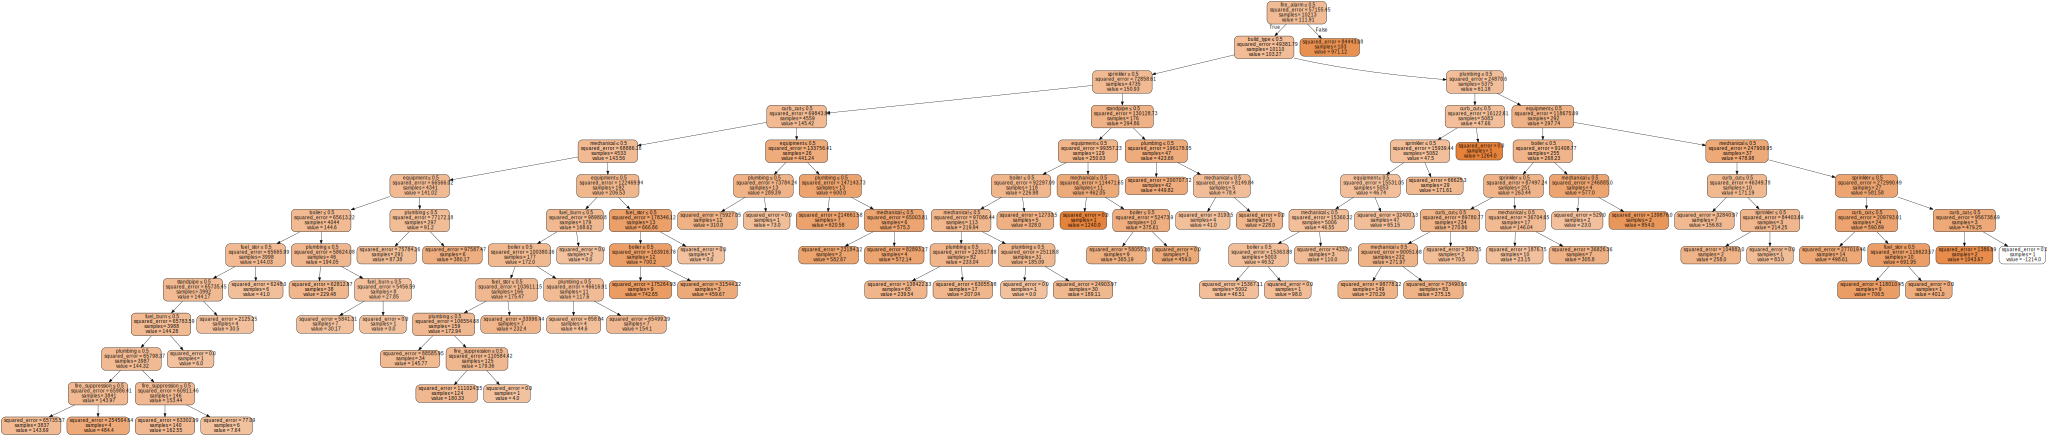

In [13]:
## start building random forest model:
x_train, x_test, y_train, y_test = train_test_split(features, labels, 
                                                    test_size = 0.2)

rgr = RandomForestRegressor(n_estimators = 100)
rgr = rgr.fit(x_train, y_train)

# Extract a single tree from the random forest
estimator = rgr.estimators_[33]
dot_data = tree.export_graphviz(estimator, out_file = None, 
                                feature_names = features.columns,  
                                class_names = None,
                                filled = True, rounded = True,  
                                proportion = False, precision = 2, 
                                special_characters=True)
# Draw graph
graph = graphviz.Source(dot_data, format = "svg") 
graph

Text(0.5, 1.0, 'Importance of Each Feature')

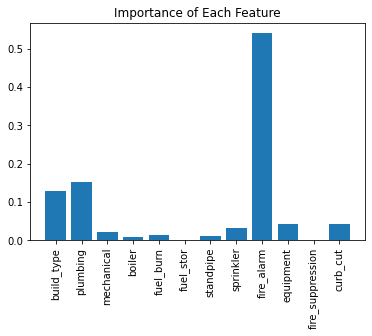

In [14]:
importances = rgr.feature_importances_

plt.bar(features.columns, importances)
plt.xticks(rotation = 90)
plt.title('Importance of Each Feature')

It seems that whether the project includes fire alarm installment is the most important feature in deciding the waiting time. The type of building and whether it includes plumbing are also two other important variables.

## Model evaluation

In [15]:
y_pred = rgr.predict(x_test)

dof = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
dof["diff"] = abs(dof["Actual"] - dof["Predicted"])
dof.sort_values(by = ['diff'], inplace = True)

print('Mean Absolute Error:', 
      metrics.mean_absolute_error(y_test, y_pred))

dof.head()

Mean Absolute Error: 122.42076765495649


,Actual,Predicted,diff
1407,47,46.702752,0.297248
890,144,143.644831,0.355169
119,144,143.644831,0.355169
3165,144,143.644831,0.355169
2986,143,143.644831,0.644831


In [16]:
dof.sort_values(by=['diff'], ascending=False,inplace=True)
dof.head()

,Actual,Predicted,diff
3398,4375,143.644831,4231.355169
3909,4363,143.644831,4219.355169
3662,4363,143.644831,4219.355169
2254,3113,46.702752,3066.297248
2718,2865,74.433661,2790.566339


The mean absolute error seems a bit large, but when we get into those cases with highest errors we will find this might be due to some severe outliers resulting in quite large errors. We may want to investigate those outliers more deeply.